# Load seismic data and fault labels from S3 and visualize

In [2]:
import boto3
import io
import numpy as np
import matplotlib.pyplot as plt

def list_s3_files(bucket_name, prefix="", extension=""):
    """
    List all files in a specific S3 directory with a given extension.

    :param bucket_name: Name of the S3 bucket.
    :param prefix: Directory path inside the bucket. (e.g., 'my-folder/')
    :param extension: File extension to filter by (e.g., '.txt', '.csv').
    :return: List of file keys matching the extension.
    """
    s3_client = boto3.client('s3')
    file_keys = []

    # Use paginator to handle large lists of files
    paginator = s3_client.get_paginator('list_objects_v2')
    operation_parameters = {'Bucket': bucket_name, 'Prefix': prefix}

    for page in paginator.paginate(**operation_parameters):
        if 'Contents' in page:
            for obj in page['Contents']:
                key = obj['Key']
                if key.endswith(extension):  # Filter by extension
                    file_keys.append(key)

    return file_keys

def get_cube_from_bytestream(bucket, filepath):
    """function returns a seismic or fault cube give the file path to the binary file in an s3 bucket"""
    s3_client = boto3.client('s3')
    byte_obj = s3_client.get_object(Bucket=bucket, Key=filepath)
    byte_stream = byte_obj['Body'].read()
    data = np.frombuffer(byte_stream, dtype=np.single).reshape(128,128,128)
    return data

In [3]:
seis_files = list_s3_files('misc-bucket-new', 'synthetic-fault-data/seismic/seismic')
fault_masks = list_s3_files('misc-bucket-new', 'synthetic-fault-data/fault/fault')

In [4]:
fault_masks

['synthetic-fault-data/fault/fault/0.dat',
 'synthetic-fault-data/fault/fault/1.dat',
 'synthetic-fault-data/fault/fault/10.dat',
 'synthetic-fault-data/fault/fault/100.dat',
 'synthetic-fault-data/fault/fault/101.dat',
 'synthetic-fault-data/fault/fault/102.dat',
 'synthetic-fault-data/fault/fault/103.dat',
 'synthetic-fault-data/fault/fault/104.dat',
 'synthetic-fault-data/fault/fault/105.dat',
 'synthetic-fault-data/fault/fault/106.dat',
 'synthetic-fault-data/fault/fault/107.dat',
 'synthetic-fault-data/fault/fault/108.dat',
 'synthetic-fault-data/fault/fault/109.dat',
 'synthetic-fault-data/fault/fault/11.dat',
 'synthetic-fault-data/fault/fault/110.dat',
 'synthetic-fault-data/fault/fault/111.dat',
 'synthetic-fault-data/fault/fault/112.dat',
 'synthetic-fault-data/fault/fault/113.dat',
 'synthetic-fault-data/fault/fault/114.dat',
 'synthetic-fault-data/fault/fault/115.dat',
 'synthetic-fault-data/fault/fault/116.dat',
 'synthetic-fault-data/fault/fault/117.dat',
 'synthetic-faul

In [5]:
seis_files

['synthetic-fault-data/seismic/seismic/0.dat',
 'synthetic-fault-data/seismic/seismic/1.dat',
 'synthetic-fault-data/seismic/seismic/10.dat',
 'synthetic-fault-data/seismic/seismic/100.dat',
 'synthetic-fault-data/seismic/seismic/101.dat',
 'synthetic-fault-data/seismic/seismic/102.dat',
 'synthetic-fault-data/seismic/seismic/103.dat',
 'synthetic-fault-data/seismic/seismic/104.dat',
 'synthetic-fault-data/seismic/seismic/105.dat',
 'synthetic-fault-data/seismic/seismic/106.dat',
 'synthetic-fault-data/seismic/seismic/107.dat',
 'synthetic-fault-data/seismic/seismic/108.dat',
 'synthetic-fault-data/seismic/seismic/109.dat',
 'synthetic-fault-data/seismic/seismic/11.dat',
 'synthetic-fault-data/seismic/seismic/110.dat',
 'synthetic-fault-data/seismic/seismic/111.dat',
 'synthetic-fault-data/seismic/seismic/112.dat',
 'synthetic-fault-data/seismic/seismic/113.dat',
 'synthetic-fault-data/seismic/seismic/114.dat',
 'synthetic-fault-data/seismic/seismic/115.dat',
 'synthetic-fault-data/sei

In [6]:
def zscore(data, Nstds=3):
    mu, sigma = data.mean(), data.std()
    data_centered = data - mu
    data_clipped = np.clip(data_centered, a_min=-Nstds*sigma, a_max=Nstds*sigma)
    data_standardized = data_clipped/(Nstds*sigma)
    return data_standardized

In [8]:
# create a pytorch dataloader

import torch
from torch.utils.data import Dataset, DataLoader
import random

class SyntheticSeismicWithGroundTruth(Dataset):
    """Dataset class for loading 3D seismic cubes with ground truth fault masks"""
    def __init__(self, bucket_name, seismic_path, fault_path):
        super().__init__()
        self.bucket_name = bucket_name
        self.list_seismic_files = list_s3_files(bucket_name, seismic_path, '.dat')
        self.list_fault_files = list_s3_files(bucket_name, fault_path, '.dat')
    
    def __len__(self):
        return len(self.list_seismic_files)
    
    def __getitem__(self, index):
        # extract the seismic and fault cubes
        seismic = get_cube_from_bytestream(self.bucket_name, self.list_seismic_files[index])
        fault = get_cube_from_bytestream(self.bucket_name, self.list_fault_files[index])
        
        # normalize the seismic data
        Nstds = random.randint(2,5)
        seismic_standardized = zscore(seismic, Nstds)
        
        # convert to torch tensor
        seismic_tensor = torch.from_numpy(seismic_standardized[np.newaxis,...]).float()
        fault_tensor = torch.from_numpy(fault[np.newaxis,...]).float()
        
        return seismic_tensor, fault_tensor
    

# Test Dataloader

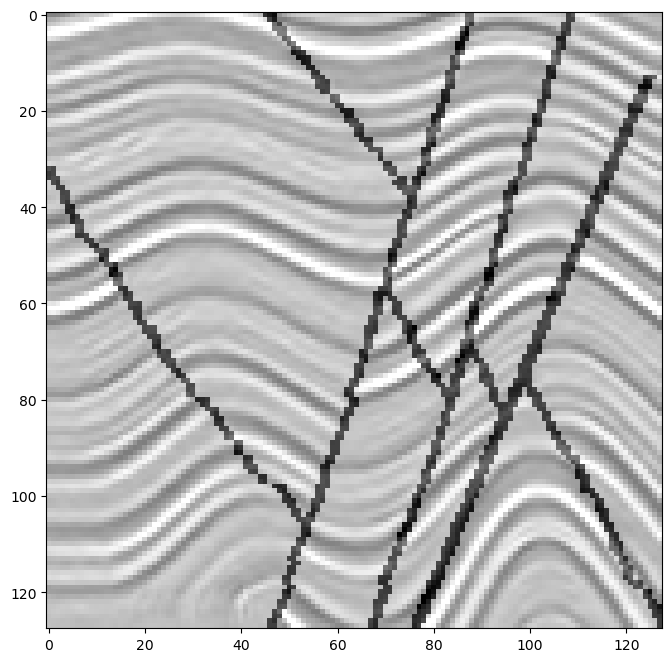

In [16]:
# file paths
bucket = 'misc-bucket-new'
seismic_path = 'synthetic-fault-data/seismic/seismic'
fault_path = 'synthetic-fault-data/fault/fault'

# create dataset and dataloader
dataset = SyntheticSeismicWithGroundTruth(bucket, seismic_path, fault_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# sample and plot from the dataloader
x, y = next(iter(dataloader))
plt.figure(figsize=(8,8))
i = random.randint(0,127)
plt.imshow(x.detach().cpu().numpy().squeeze()[i].T, cmap='gray', vmin=-1, vmax=1)
plt.imshow(y.detach().cpu().numpy().squeeze()[i].T, cmap='Greys', vmin=0, vmax=1, alpha=0.5)
plt.show()